Задача в этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).

# **1. Подключаем библиотеки и скрипты**

In [1654]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gb-credit-default/sample_submission.csv
/kaggle/input/gb-credit-default/train.csv
/kaggle/input/gb-credit-default/test.csv


In [1655]:
import numpy as np
import pandas as pd
import random
import catboost as catb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1656]:
import warnings
warnings.filterwarnings('ignore')

In [1657]:
matplotlib.rcParams.update({'font.size': 14})

In [1658]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [1659]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

# **2. Загружаем данные**

In [1660]:
TRAIN_DATASET_PATH = '/kaggle/input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '/kaggle/input/gb-credit-default/test.csv'

 Описание датасета:
* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые льготы
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Score - кредитный скоринг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1661]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


Обратим внимание на странное значение признака **Current Loan Amount** и на наличие пропусков в колонках **Annual Income**, **Years in current job**, **Months since last delinquent**, **Credit Score**

In [1662]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [1663]:
print('Строк в трейне:', df.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


# **3. EDA**

Посмотрим на баланс классов:

In [1664]:
TARGET_NAME = 'Credit Default'
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Налицо существенный дисбаланс классов. Целевая переменная является дискретной, поэтому необходимо сравнивать распределение целевой переменной в разрезе других переменных.

Ознакомимся с типами переменных

In [1665]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

Построим матрицу корреляций признаков и целевой переменной:

In [1666]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

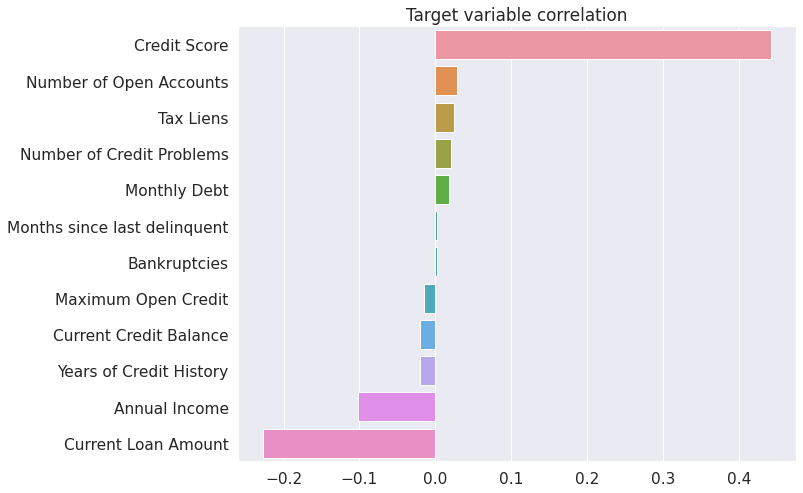

In [1667]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Target variable correlation')
plt.show()

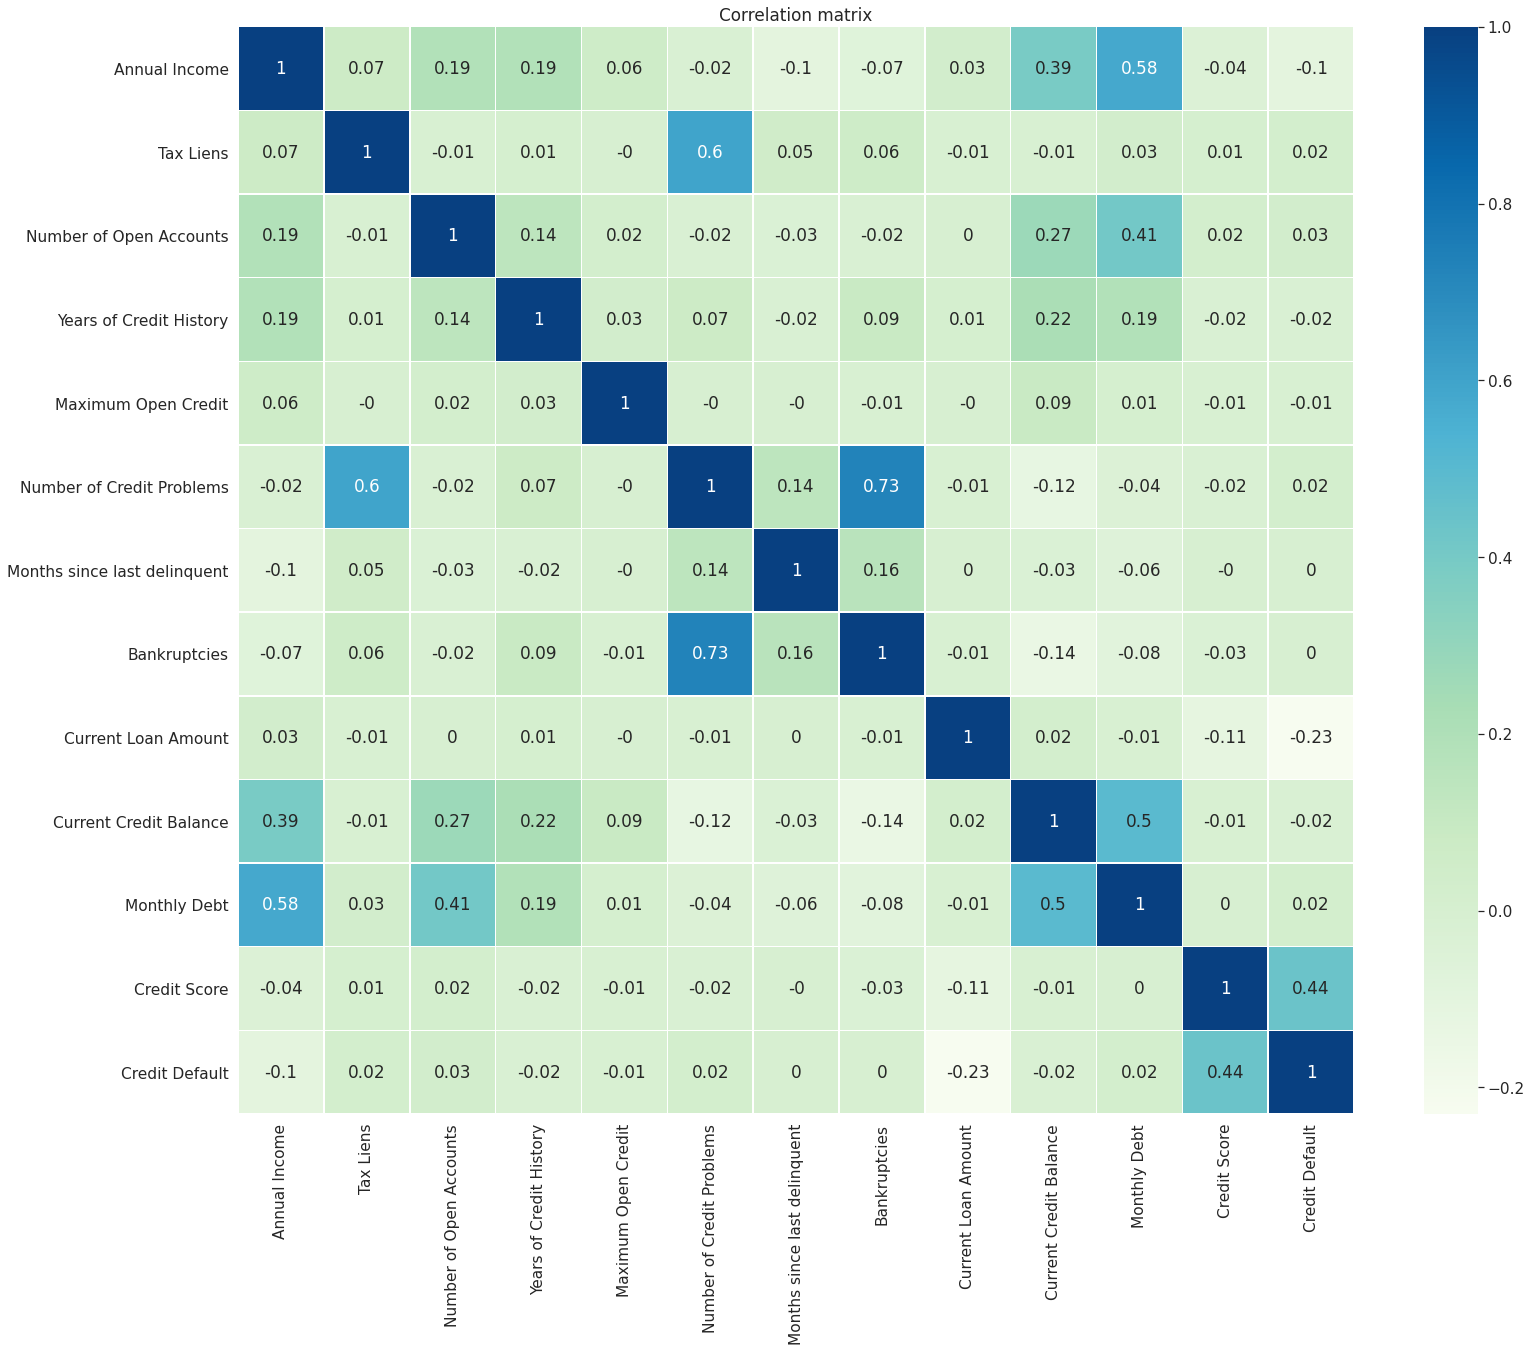

In [1668]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
corr_matrix = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr()
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Отметим, что целевая переменная имеет среднюю прямую корреляцию с признаком Credit Score и средне-низкую обратную корреляцию с признаком Current Loan Amount. С остальными признаками целевая переменная коррелирует слабо.

После устранения возможных выбросов и NaN обратим внимание на распределение целевой переменной в разрезе двух упомянутых выше факторов.

Изучим **количественные** переменные в задаче на предмет возможных выбросов и NaN:

In [1669]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обратим внимание на признаки, по которым существует значительная разница между средним значением и значением 50-го персентиля: Maximum Open Credit, Current Loan Amount, Credit score, Bankrupcies**

Для подтверждения наших опасений, визуализируем значения количественных признаков:

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

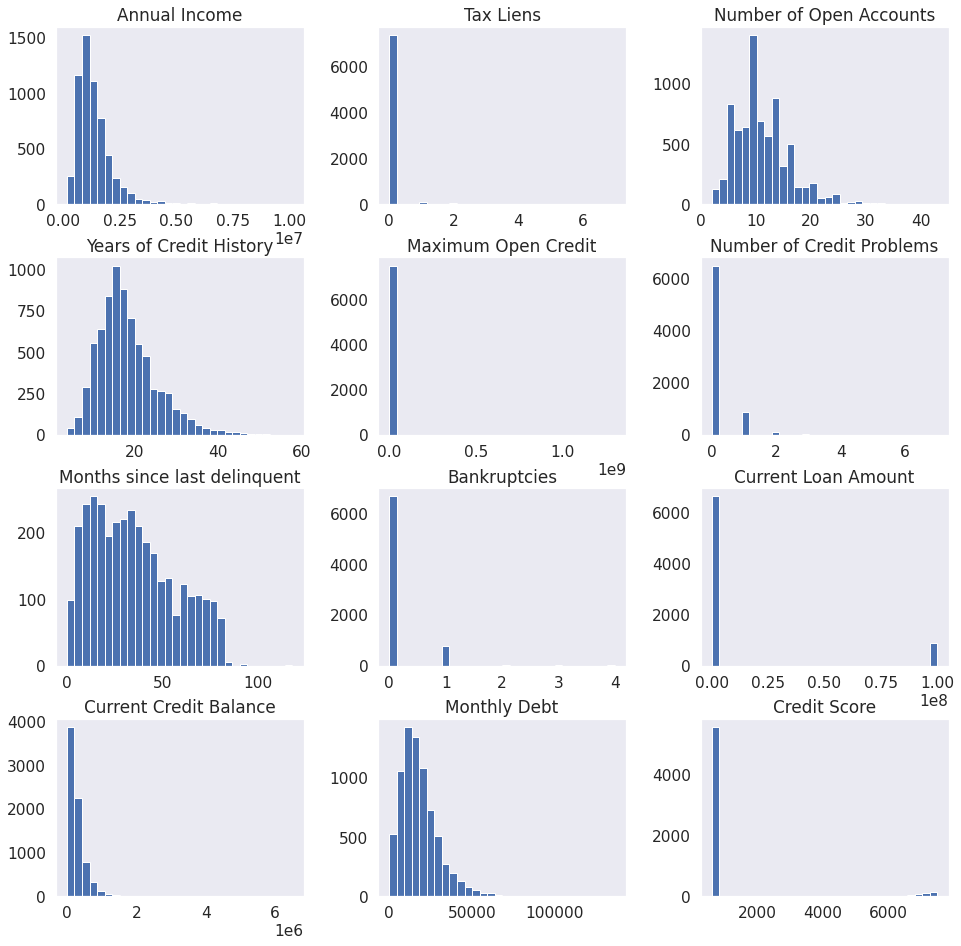

In [1670]:
df.select_dtypes(include='float64').hist(figsize=(16,16), bins=30, grid=False, log=False)

Судя по графикам распределения, наши опасения относительно указанных выше признаков подтвердились. Обработаем выбросы по ним поочеередно в следующем этапе.

Изучим категориальные переменные:

In [1671]:
df_cat_features = df.select_dtypes(include=['object'])

In [1672]:
df_cat_features.describe()

,Home Ownership,Years in current job,Purpose,Term
count,7500,7129,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2332,5944,5556


Отметим наличие пропусков в Years in current job

In [1673]:
CAT_FEATURE_NAMES = df_cat_features.columns.to_list()
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [1674]:
for cat_colname in df_cat_features.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_cat_features[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Отметим существенный дисбаланс признаков в Years In Current Job, Purpose, Term. 
Также присутствует очевидный выброс в Home Ownership.
Поправим в следующем пункте.

# **4. Обработка выбросов и NaN, генерация фич**

**4.1 Выбросы**

**Количественные признаки**

Начнем с признака **Credit Score**.
Детальнее взглянем на его распределение:

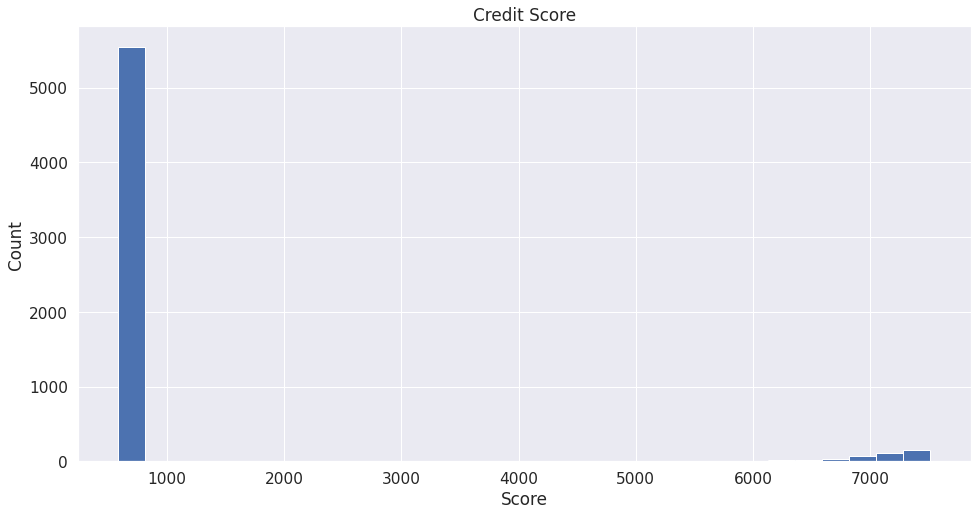

In [1675]:
plt.figure(figsize = (16, 8))

df['Credit Score'].plot(kind='hist', bins=30)
plt.ylabel('Count')
plt.xlabel('Score')

plt.title('Credit Score')
plt.show()

Видно, что большинство значений лежат в диапазоне [0;1000]; кроме того, известно, что кредитный рейтинг не может превышать значение 850; значения, находящиеся в правой нижней части графика будем считать выбросами.
Предположим, что они были ошибочно занесены с неверно проставленной запятой (больше в 10 раз, чем было необходимо). Тогда перенесем запятую для таких значений на один знак влево.

In [1676]:
df.loc[df['Credit Score'] > 850, 'Credit Score'] = df['Credit Score']/10

Теперь рассмотрим признак **Current Loan Amount**. Выведем 10 наибольших значений:

In [1677]:
df.nlargest(10, 'Current Loan Amount')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0
30,Rent,612750.0,7 years,0.0,8.0,14.0,225016.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,147687.0,6128.0,719.0,0
31,Own Home,1289796.0,10+ years,0.0,11.0,20.5,845548.0,0.0,NaN,0.0,debt consolidation,Long Term,99999999.0,640433.0,26549.0,708.0,0
46,Home Mortgage,1721457.0,10+ years,0.0,6.0,27.3,263604.0,0.0,6.0,0.0,debt consolidation,Short Term,99999999.0,121353.0,23527.0,723.0,0
61,Home Mortgage,866476.0,1 year,0.0,15.0,12.9,239800.0,0.0,NaN,0.0,debt consolidation,Long Term,99999999.0,130891.0,11770.0,701.0,0
67,Rent,1269333.0,< 1 year,0.0,7.0,15.8,235510.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,171874.0,5183.0,747.0,0


Значение 999999999.0, очевидно, некорректное. Подсчитаем количество таких значений:

In [1678]:
df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

Таких значений достаточно много, поэтому просто избавиться от них нельзя. Предположим, что текущая сумма займа может быть связана с целью кредита и его условиями, и заменим выбросы медианными значениями в привязке к признакам Term, Purpose и Current Loan Amount.

In [1679]:
df_cur_amount = df[df['Current Loan Amount'] < 99999999.0][['Purpose', 'Term', 'Current Loan Amount']]
df_cur_amount = df_cur_amount.groupby(by=['Purpose', 'Term']).median().reset_index().rename(columns={'Current Loan Amount':'Current Loan Amount Med'})

In [1680]:
df = df.merge(df_cur_amount, on=(['Purpose','Term']), how='left')

In [1681]:
df.loc[(df['Current Loan Amount'] >= 99999999),'Current Loan Amount'] = df['Current Loan Amount Med']

Убедимся, что неподходящих значений больше не осталось:

In [1682]:
df['Current Loan Amount'].value_counts()

230857.0    573
432476.0    113
138688.0     57
215666.0     51
435160.0     14
           ... 
449746.0      1
132154.0      1
222860.0      1
104324.0      1
191136.0      1
Name: Current Loan Amount, Length: 5395, dtype: int64

Посмотрим на признак **Maximum Open Credit**. Выведем 10 наибольших значений

In [1683]:
df.nlargest(10, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Med
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0,230857.0
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0,107910.0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0,138688.0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0,138688.0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,215666.0,1908550.0,5770.0,743.0,0,215666.0
7026,Home Mortgage,3312365.0,5 years,0.0,13.0,25.3,2.640700e+07,0.0,50.0,0.0,home improvements,Long Term,435160.0,2440246.0,39196.0,745.0,0,435160.0
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,2.634333e+07,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0,215666.0
5523,Home Mortgage,1520304.0,10+ years,0.0,21.0,35.5,2.137243e+07,0.0,0.0,0.0,other,Long Term,349459.0,1975012.0,12555.0,728.0,0,349459.0
5731,Home Mortgage,1475198.0,8 years,0.0,10.0,24.9,1.928043e+07,0.0,NaN,0.0,debt consolidation,Short Term,230857.0,1132286.0,17543.0,751.0,0,230857.0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0,140294.0


3 наибольших значения выглядят подозрительно. Заменим их значениями из 97,5-го квантиля

In [1684]:
quantile_Maximum_Open_Credit = df['Maximum Open Credit'].quantile(.975)
df.loc[(df['Maximum Open Credit'] >= 99999999),'Maximum Open Credit'] = quantile_Maximum_Open_Credit

Нулевые значения заменим на Current Loan Amount, сделав допущение о том, что как минимум текущий кредит в истории заемщика был

In [1685]:
df.loc[(df['Maximum Open Credit'] == 0),'Maximum Open Credit'] = df['Current Loan Amount']

**Категориальные признаки**

Обработаем некорректные значения по признаку **Home Ownership**, заменив Have Mortgage на Home Mortgage

In [1686]:
df.loc[df['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

**4.2 NaN**

Посмотрим количество значений с пропусками в нашей выборке:

In [1687]:
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Current Loan Amount Med            0
dtype: int64

Наибольшее количество пропусков по признаку **Months since last delinquent**. Сделаем допущение о том, что NaN в данном случае говорит, что клиент не пропускал дедлайны по платежам. Тогда заполним пустые поля нулями.

In [1688]:
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

Далее рассмотрим **Annual Income**. Из матрицы корреляций, построенной во втором пункте, видно, что наибольшая линейная взаимосвязь у этого признака с **Monthly Debt**. Тогда заполним пропуски медианой в соответствии со значением **Monthly Debt**.

In [1689]:
df['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

 Сгруппируем значения признака Monthly Debt по персентилям:

In [1690]:
bins = pd.cut(df['Monthly Debt'], [-1, 10000, 16000, 23000, 140000], labels = ['A','B','C','D'])
df['Monthly Debt Size'] = bins

bins_test = pd.cut(df_test['Monthly Debt'], [-1, 10000, 16000, 23000, 140000], labels = ['A','B','C','D'])
df_test['Monthly Debt Size'] = bins_test

In [1691]:
median_income_by_debt = df.groupby('Monthly Debt Size', as_index=False).agg({'Annual Income':'median'})
median_income_by_debt

,Monthly Debt Size,Annual Income
0,A,835601.0
1,B,971565.0
2,C,1197323.0
3,D,1740371.5


In [1692]:
df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']=='A'), 'Annual Income'] = 835601.0
df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']=='B'), 'Annual Income'] = 971565.0
df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']=='C'), 'Annual Income'] = 1196848.0
df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']=='D'), 'Annual Income'] = 1740476.0

df_test.loc[(df_test['Annual Income'].isnull()) & (df_test['Monthly Debt Size']=='A'), 'Annual Income'] = 835601.0
df_test.loc[(df_test['Annual Income'].isnull()) & (df_test['Monthly Debt Size']=='B'), 'Annual Income'] = 971565.0
df_test.loc[(df_test['Annual Income'].isnull()) & (df_test['Monthly Debt Size']=='C'), 'Annual Income'] = 1196848.0
df_test.loc[(df_test['Annual Income'].isnull()) & (df_test['Monthly Debt Size']=='D'), 'Annual Income'] = 1740476.0

Пропуски по **Years in current job** заполним модой

In [1693]:
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

Пропусков по **Bankruptcies** мало, поэтому заполним их нулями.

In [1694]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

Пропуски в **Credit Score** заполним медианами в соответствии со значениями **Bankrupcies**, **Number of credit problems**, **Years of credit history**

In [1695]:
median_сredit_score_by_term_ownership = df.groupby(by=['Bankruptcies','Number of Credit Problems', 'Years of Credit History']).agg({'Credit Score':'median'}).rename(columns={'Credit Score':'Credit Score Med'})
median_сredit_score_by_term_ownership
df = df.merge(median_сredit_score_by_term_ownership, on=(['Bankruptcies','Number of Credit Problems', 'Years of Credit History']), how = 'left')
df.loc[(df['Credit Score'].isna()),'Credit Score'] = df['Credit Score Med']

In [1696]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Med,Credit Score Med
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7418.000000,7500.000000,7500.000000,7418.000000
mean,1.332575e+06,0.030133,11.130933,18.317467,6.882011e+05,0.170000,15.815200,0.116933,302415.311733,2.898332e+05,18314.454133,721.540307,0.281733,270832.510667,727.195066
std,7.727127e+05,0.271604,4.908924,7.041946,1.263012e+06,0.498598,22.649441,0.346904,174684.825039,3.178714e+05,11926.764673,25.630014,0.449874,97298.775323,11.226067
min,1.645970e+05,0.000000,2.000000,4.000000,4.334000e+03,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,21912.000000,594.000000
25%,8.451675e+05,0.000000,8.000000,13.500000,2.812755e+05,0.000000,0.000000,0.000000,177325.500000,1.142565e+05,10067.500000,713.000000,0.000000,230857.000000,723.000000
50%,1.168557e+06,0.000000,10.000000,17.000000,4.796770e+05,0.000000,0.000000,0.000000,254331.000000,2.093230e+05,16076.500000,729.000000,0.000000,230857.000000,729.000000
75%,1.668404e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,415646.000000,3.604062e+05,23818.000000,739.000000,1.000000,349459.000000,733.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000,522885.000000,751.000000


Объявим класс **DataPreprocessing**, где зафиксируем наши наработки по предобработке данных:

In [1697]:
class DataPreprocessing():  
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.quantile_Maximum_Open_Credit = None
        self.df_cur_amount = None
        self.coef_Annual_Incomeby_Monthly_Debt = None
        self.median_bankruptcies_by_credit_problems = None
        self.median_сredit_score_by_term_ownership = None
        self.mode_Years_in_current_job = None
        
    def fit(self, X):
        """Сохранение статистик"""
        X = X.copy()        
        self.medians = X.median()
        self.quantile_Maximum_Open_Credit = X['Maximum Open Credit'].quantile(.975)
        self.df_cur_amount = X[X['Current Loan Amount'] < 999999999][['Purpose','Term','Current Loan Amount']]
        self.df_cur_amount = X.groupby(by=['Purpose','Term'])\
                              .median()\
                              .reset_index()\
                              .rename(columns={'Current Loan Amount':'Current Loan Amount Med'})
        self.coef_Annual_Incomeby_Monthly_Debt = X[X['Annual Income'].notna()][['Annual Income','Monthly Debt']]\
                                                                     .median()[0] / df[df['Annual Income']\
                                                                                       .notna()][['Annual Income','Monthly Debt']]\
                                                                                       .median()[1]
        self.median_сredit_score_by_term_ownership = X.groupby(by=['Bankruptcies', 'Number of Credit Problems', 'Years of Credit History'])\
                                                      .agg({'Credit Score':'median'})\
                                                      .rename(columns={'Credit Score':'Credit Score Med'})
        self.mode_Years_in_current_job = X['Years in current job'].mode()[0]      
        
    def transform(self, X):
        """Трансформация данных"""

        #Обработка выбросов
        #Maximum Open Credit
        X.loc[(X['Maximum Open Credit'] >= 99999999),'Maximum Open Credit'] = quantile_Maximum_Open_Credit
        X.loc[(X['Maximum Open Credit'] == 0),'Maximum Open Credit'] = X['Current Loan Amount']
        
        #Current Loan Amount 
        X = X.merge(df_cur_amount, on=(['Purpose','Term']), how='left')
        X.loc[(X['Current Loan Amount'] >= 99999999),'Current Loan Amount'] = X['Current Loan Amount Med']
        
        #Credit Score
        X.loc[X['Credit Score'] > 850, 'Credit Score'] = X['Credit Score']/10
        
        #Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        #Обработка пропусков
        #Annual Income
        X.loc[(X['Annual Income'].isna()),'Annual Income'] = X['Monthly Debt'] * self.coef_Annual_Incomeby_Monthly_Debt
        
        #Months since last delinquent
        X.loc[X['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
        
        #Bankruptcies
        X.loc[X['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
        
        #Credit Score
        X = X.merge(self.median_сredit_score_by_term_ownership, 
                    on=(['Bankruptcies', 'Number of Credit Problems', 'Years of Credit History']), 
                    how = 'left')
        X.loc[(X['Credit Score'].isna()),'Credit Score'] = X['Credit Score Med']
        
        #Years in current job
        X.loc[(X['Years in current job'].isna()),'Years in current job'] = self.mode_Years_in_current_job
        
        #Удаление ненужных признаков
        X.drop('Current Loan Amount Med', axis=1, inplace=True)
        X.drop('Credit Score Med', axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

**4.3 Генерация фич**

**Term** -  заменим Short term и Long term на 0 и 1 соответственно:

In [1698]:
df['Long Term'] = df['Term'].map({'Long Term': 1, 'Short Term': 0})

Создадим Dummies на основе признака **Home Ownership**

In [1699]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)

**Years in current job** - сделаем разбивку на 4 группы по годам: <3, 4-6, 7-9, 10<:

In [1700]:
df['Years in current job'] = df['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})

**Credit Score** - сделаем разбивку по категориям:
* Excellent: 800 to 850
* Very Good: 740 to 799
* Good: 670 to 739
* Fair: 580 to 669
* Poor: 300 to 579

In [1701]:
def credit_score_to_cat(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['Credit Score Cat'].fillna(-1, inplace=True)
    return X

In [1702]:
df = credit_score_to_cat(df)

Объединим наши наработки в класс **FeatureGenerator**:

In [1703]:
class FeatureGenetator():
    """Генерация новых фич"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # Term
        X['Long Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        # Years in current job
        X['Years in current job'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})
        # Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # Credit Score
        X = self.credit_score_to_cat(X)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

# **5. Отбор признаков**

In [1704]:
feature_names = ['Annual Income', 
                 'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History', 
                 'Maximum Open Credit', 
                 'Number of Credit Problems',  
                 'Bankruptcies',
                 'Current Loan Amount', 
                 'Current Credit Balance', 
                 'Monthly Debt', 
                 'Credit Score', 
                 'Years in current job',
                ]

new_feature_names = ['Long Term',
                     'Home Mortgage',
                     'Own Home',
                     'Rent',
                     'Credit Score Cat'
                    ]

target_name = 'Credit Default'

# **6. Разбиение на Train и Test**

In [1705]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [1706]:
X = df.drop(columns=target_name)
y = df[target_name]

In [1707]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [1708]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)  #  fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

In [1709]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 17), (2475, 17), (2500, 17))

In [1710]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)  #  fit применяем только к X_train, y_train

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

In [1711]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 22), (2475, 22), (2500, 22))

Оставляем только отобранные в разделе 5 признаки:

In [1712]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [1713]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 17), (2475, 17), (2500, 17))

In [1714]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [1715]:
X_train.isna().sum()

Annual Income                0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Years in current job         0
Long Term                    0
Home Mortgage                0
Own Home                     0
Rent                         0
Credit Score Cat             0
dtype: int64

# **7. Построение модели**

In [1716]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5537482319660536

In [1717]:
model_catb = catb.CatBoostClassifier(
                                     silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=50,
                                     max_depth=5,
                                     min_data_in_leaf=5
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1718]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN
 0.518
TEST
 0.501
TRAIN

              precision    recall  f1-score   support

           0       0.84      0.61      0.71      3611
           1       0.41      0.70      0.52      1414

    accuracy                           0.64      5025
   macro avg       0.62      0.65      0.61      5025
weighted avg       0.72      0.64      0.65      5025

VALID

              precision    recall  f1-score   support

           0       0.82      0.60      0.69      1776
           1       0.40      0.68      0.50       699

    accuracy                           0.62      2475
   macro avg       0.61      0.64      0.60      2475
weighted avg       0.70      0.62      0.64      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1061  715
1                226  473


In [1719]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,33.728601
12,Long Term,14.936610
0,Annual Income,13.639978
10,Credit Score,7.744846
9,Monthly Debt,4.916959
16,Credit Score Cat,4.079037
3,Years of Credit History,3.828844
4,Maximum Open Credit,3.188888
2,Number of Open Accounts,2.985402
11,Years in current job,2.433814


Прогнозирование на тестовом датасете:

In [1720]:
df_test.shape

(2500, 17)

In [1721]:
submit = pd.read_csv('../input/gb-credit-default/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [1722]:
predictions = model_catb.predict(df_test)
predictions

array([1, 1, 0, ..., 1, 0, 1])

In [1723]:
len(predictions)

2500

In [1724]:
submit['Credit Default'] = predictions

In [1725]:
submit.to_csv('submit.csv', index=False)